In [84]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad

In [85]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2021-11-30 21:50:47--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.1’

postgresql-42.2.9.j 100%[===================>] 892.61K  5.26MB/s    in 0.2s    

2021-11-30 21:50:48 (5.26 MB/s) - ‘postgresql-42.2.9.jar.1’ saved [914037/914037]



In [86]:
# Starting the spark session:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

Importing Red & White Wine CSV from Amazon AWS

In [87]:
#read in the dataframes
# Read in data from S3 Buckets 
from pyspark import SparkFiles
url="https://cliff-penn-bucket.s3.amazonaws.com/winequality-red.csv"
spark.sparkContext.addFile(url)
red_wine_df = spark.read.csv(SparkFiles.get("winequality-red.csv"), sep=";", header=True, inferSchema=True)

# Show DataFrame
red_wine_df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [88]:
url="https://cliff-penn-bucket.s3.amazonaws.com/winequality-white.csv"
spark.sparkContext.addFile(url)
white_wine_df = spark.read.csv(SparkFiles.get("winequality-white.csv"), sep=";", header=True, inferSchema=True)

# Show DataFrame
white_wine_df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|
|          7.2|            0.23|       0.32|           8.5|    0.058|               47.0|           

Data Processing steps:

*   Add a columm called Wine type to each data frame and add a value of 1 to denote red wine and 0 for white wine

*   Append The red wine data frame to white wine dataframe randomly to make one dataFrame




In [89]:
#Add a columm called Wine type to each data frame and add a value of 1 to denote red wine and 0 for white wine
from pyspark.sql.functions import lit
white_wine_df = white_wine_df.withColumn("Wine Type", lit(0))

In [90]:
#Add a columm called Wine type to each data frame and add a value of 1 to denote red wine and 0 for white wine
#Also called feature
red_wine_df = red_wine_df.withColumn("Wine Type", lit(1))

In [91]:
#Merge both Dataframes to form one dataframe using union
Merged_Wine_df = red_wine_df.union(white_wine_df)

In [92]:
Merged_Wine_df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|Wine Type|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+---------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|        1|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|        1|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|        1|
|         11.2|            0.28|       0

In [93]:
# SQL has some keywords such a Type and volatile and using those names when trying to create schemas will cause issues so I have to rename some of the columms.
Merged_Wine_df =Merged_Wine_df.withColumnRenamed('Wine Type','Wine_Type')\
.withColumnRenamed('volatile acidity','volatile_acidity')\
.withColumnRenamed('free sulfur dioxide','free_sulfur_dioxide')\
.withColumnRenamed('fixed acidity', 'fixed_acidity')\
.withColumnRenamed('citric acid','citric_acid')\
.withColumnRenamed('residual sugar','residual_sugar')\
.withColumnRenamed('total sulfur dioxide','total_sulfur_dioxide')



Configuring data for RDS 
*   creating a table called Wine data
*   Use Amazon RDS to load the data in Posgres SQL





In [94]:
# Configure settings for RDS
mode = "append"
jdbc_url="jdbc:postgresql://aws-cliff-penn-db.cceezfgk7xh7.us-east-1.rds.amazonaws.com:5432/postgres"
config = {"user":"postgres", 
          "password": "Walnut69#$", 
          "driver":"org.postgresql.Driver"}

In [95]:
#writing the Dataframe to wine
Merged_Wine_df.write.jdbc(url=jdbc_url, table='wine_data', mode=mode, properties=config)

In [96]:
type(Merged_Wine_df)


pyspark.sql.dataframe.DataFrame

**In order to continue with Machine Learning part of this project, I have converted the Pyspark Dataframe to A Pandas DataFrame**

In [97]:
# convert the data to pyspark dataframe to pandas dataframe.
pd_Wine_df = Merged_Wine_df.toPandas()
pd_Wine_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Wine_Type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.preprocessing import StandardScaler



In [99]:
# because the red is at the top of the dataframe and the white wine is at the bottom of the dataframe, we are going to use sklearn to randomly shuffle the dataframes.

from sklearn.utils import shuffle
pd_Wine_df = shuffle(pd_Wine_df)
pd_Wine_df.reset_index(inplace=True, drop=True)
pd_Wine_df.head(20)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Wine_Type
0,5.7,0.280,0.24,17.5,0.044,60.0,167.0,0.99890,3.31,0.44,9.40,5,0
1,7.6,0.200,0.26,4.5,0.086,37.0,133.0,0.99630,3.15,0.42,9.20,5,0
2,6.7,0.150,0.29,5.0,0.058,28.0,105.0,0.99460,3.52,0.44,10.20,7,0
3,7.1,0.260,0.37,5.5,0.025,31.0,105.0,0.99082,3.06,0.33,12.60,8,0
4,6.2,0.440,0.39,2.5,0.077,6.0,14.0,0.99555,3.51,0.69,11.00,6,1
5,7.1,0.140,0.35,1.4,0.039,24.0,128.0,0.99212,2.97,0.68,10.40,5,0
6,6.1,0.255,0.44,12.3,0.045,53.0,197.0,0.99670,3.24,0.54,9.50,6,0
7,7.0,0.180,0.37,1.5,0.043,16.0,104.0,0.99216,3.18,0.50,10.80,5,0
8,7.4,0.260,0.30,7.9,0.049,38.0,157.0,0.99630,3.13,0.48,8.90,6,0
9,6.2,0.260,0.20,8.0,0.047,35.0,111.0,0.99445,3.11,0.42,10.40,6,0


Splitting the dataset into manual testing and machine learning data sets
This is achieved by taking the top 5 rows and bottom 5 rows and joining them together, these rows are also removed from the dataset.




In [100]:
pd_Wine_df.shape

(6497, 13)

In [101]:
pd_Wine_df['quality'].value_counts

<bound method IndexOpsMixin.value_counts of 0       5
1       5
2       7
3       8
4       6
       ..
6492    7
6493    7
6494    6
6495    5
6496    6
Name: quality, Length: 6497, dtype: int32>

In [102]:
#creating the manual testing  datasets by taking the last 20 rows of the data set
Manual_wine_test_df = pd_Wine_df.tail(20)
#removing the manual testing dataframes from our wine dataset by iterating through the all rows
for i in range (6496, 6476, -1):
  pd_Wine_df.drop([i], axis = 0, inplace = True)


In [103]:
Manual_wine_test_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Wine_Type
6477,6.9,0.320,0.15,8.10,0.046,51.0,180.0,0.99580,3.13,0.45,8.9,5,0
6478,7.0,0.290,0.33,0.90,0.041,20.0,117.0,0.99048,3.21,0.50,11.4,5,0
6479,7.1,0.180,0.74,15.60,0.044,44.0,176.0,0.99960,3.38,0.67,9.0,6,0
6480,5.4,0.740,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5,6,1
6481,6.1,0.380,0.14,3.90,0.060,27.0,113.0,0.99344,3.07,0.34,9.2,4,0
6482,6.0,0.430,0.34,7.60,0.045,25.0,118.0,0.99222,3.03,0.37,11.0,6,0
6483,6.7,0.300,0.50,12.10,0.045,38.0,127.0,0.99740,3.04,0.53,8.9,6,0
6484,6.9,0.210,0.62,6.30,0.042,7.0,109.0,0.99358,2.96,0.59,10.2,6,0
6485,5.9,0.540,0.00,0.80,0.032,12.0,82.0,0.99286,3.25,0.36,8.8,5,0
6486,7.8,0.550,0.35,2.20,0.074,21.0,66.0,0.99740,3.25,0.56,9.2,5,1


In [104]:
#for manual testing purposes we will not need our target "quality" and also our "wine type columns so those need to be dropped"
final_Manual_wine_test_df = Manual_wine_test_df.drop(['quality', 'Wine_Type'], axis = 1)
final_Manual_wine_test_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
6477,6.9,0.320,0.15,8.10,0.046,51.0,180.0,0.99580,3.13,0.45,8.9
6478,7.0,0.290,0.33,0.90,0.041,20.0,117.0,0.99048,3.21,0.50,11.4
6479,7.1,0.180,0.74,15.60,0.044,44.0,176.0,0.99960,3.38,0.67,9.0
6480,5.4,0.740,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5
6481,6.1,0.380,0.14,3.90,0.060,27.0,113.0,0.99344,3.07,0.34,9.2
6482,6.0,0.430,0.34,7.60,0.045,25.0,118.0,0.99222,3.03,0.37,11.0
6483,6.7,0.300,0.50,12.10,0.045,38.0,127.0,0.99740,3.04,0.53,8.9
6484,6.9,0.210,0.62,6.30,0.042,7.0,109.0,0.99358,2.96,0.59,10.2
6485,5.9,0.540,0.00,0.80,0.032,12.0,82.0,0.99286,3.25,0.36,8.8
6486,7.8,0.550,0.35,2.20,0.074,21.0,66.0,0.99740,3.25,0.56,9.2


### Visualizing and exploration of the data
Visualizing the data helps us to understand how each feature affects the target in this case the wine quality

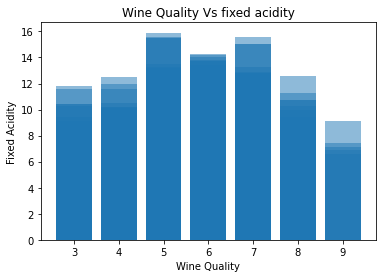

In [105]:
# WIne Quality Vs fixed acidity
plt.bar(pd_Wine_df['quality'],pd_Wine_df['fixed_acidity'] , alpha =0.5, align="center")
plt.title("Wine Quality Vs fixed acidity")
plt.xlabel("Wine Quality")
plt.ylabel("Fixed Acidity")

plt.show()

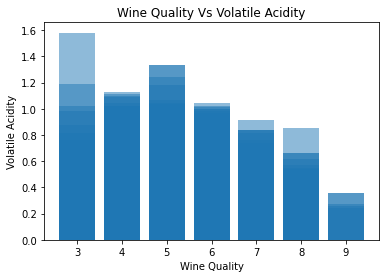

In [106]:
# Wine Quality Vs Volatile Acidity
plt.bar(pd_Wine_df['quality'], pd_Wine_df['volatile_acidity'] , alpha =0.5, align="center")
plt.title("Wine Quality Vs Volatile Acidity")
plt.xlabel("Wine Quality")
plt.ylabel("Volatile Acidity")

plt.show()

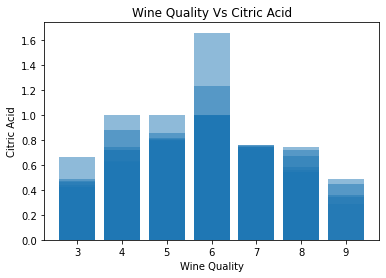

In [107]:
# Wine Quality Vs Citric Acid
plt.bar(pd_Wine_df['quality'], pd_Wine_df['citric_acid'] , alpha =0.5, align="center")
plt.title("Wine Quality Vs Citric Acid")
plt.xlabel("Wine Quality")
plt.ylabel("Citric Acid")

plt.show()

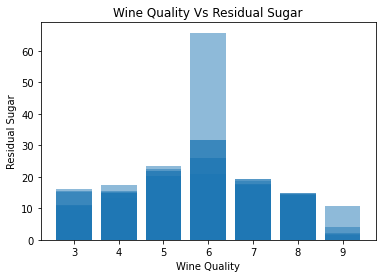

In [108]:
# Wine Quality Vs residual_sugar
plt.bar(pd_Wine_df['quality'], pd_Wine_df['residual_sugar'] , alpha =0.5, align="center")
plt.title("Wine Quality Vs Residual Sugar")
plt.xlabel("Wine Quality")
plt.ylabel("Residual Sugar")

plt.show()

In [109]:
# Dropping Wine Quality which is our target to create the X data and also dropping the wine type so as not to skew the dataset and results.

X = pd_Wine_df.drop(['quality', 'Wine_Type'], axis = 1)

In [110]:
#setting quality is our target and doing a binarization of the dataset 
y = pd_Wine_df["quality"].apply(lambda y_value: 1 if y_value>=7 else 0)

In [111]:
#splitting the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=2)

In [112]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [113]:
# initialize logistic regression model
lr = LogisticRegression()
lr

LogisticRegression()

In [114]:
#fitting the model
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)
confusion_matrix(y_test,y_pred)

array([[987,  53],
       [190,  66]])

In [115]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1040
           1       0.55      0.26      0.35       256

    accuracy                           0.81      1296
   macro avg       0.70      0.60      0.62      1296
weighted avg       0.78      0.81      0.78      1296



In [116]:
#Evaluating the model
print(f'Training Score: {lr.score(X_train_scaled, y_train)}')
print(f'Testing Score: {lr.score(X_test_scaled, y_test)}')

Training Score: 0.818567844045551
Testing Score: 0.8125


### Time to Try the Random Forest Classifier 

In [119]:
#Initialize Random Forest Classifier Model
rc = RandomForestClassifier()

In [120]:
#fitting the Random Forest Classifier Model
rc.fit(X_train_scaled, y_train)


RandomForestClassifier()

Random Forest Classifier Accuracy Evaluation

In [121]:
y_pred2 = rc.predict(X_test_scaled)
confusion_matrix(y_test,y_pred2)

array([[996,  44],
       [116, 140]])

In [122]:
print(f'Training Score: {rc.score(X_train_scaled, y_train)}')
print(f'Testing Score: {rc.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.8765432098765432


Trying Support Vector Machine.



In [123]:
from sklearn.svm import SVC 
sv = SVC(kernel='linear')
sv.fit(X_train_scaled, y_train)
y_pred3 = sv.predict(X_test_scaled)
confusion_matrix(y_test,y_pred3)

array([[1040,    0],
       [ 256,    0]])

In [124]:
print(f'Training Score: {sv.score(X_train_scaled, y_train)}')
print(f'Testing Score: {sv.score(X_test_scaled, y_test)}')

Training Score: 0.8033198224281027
Testing Score: 0.8024691358024691


###Manual Testing


In [128]:
Manual_wine_test_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,Wine_Type
6477,6.9,0.320,0.15,8.10,0.046,51.0,180.0,0.99580,3.13,0.45,8.9,5,0
6478,7.0,0.290,0.33,0.90,0.041,20.0,117.0,0.99048,3.21,0.50,11.4,5,0
6479,7.1,0.180,0.74,15.60,0.044,44.0,176.0,0.99960,3.38,0.67,9.0,6,0
6480,5.4,0.740,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5,6,1
6481,6.1,0.380,0.14,3.90,0.060,27.0,113.0,0.99344,3.07,0.34,9.2,4,0
6482,6.0,0.430,0.34,7.60,0.045,25.0,118.0,0.99222,3.03,0.37,11.0,6,0
6483,6.7,0.300,0.50,12.10,0.045,38.0,127.0,0.99740,3.04,0.53,8.9,6,0
6484,6.9,0.210,0.62,6.30,0.042,7.0,109.0,0.99358,2.96,0.59,10.2,6,0
6485,5.9,0.540,0.00,0.80,0.032,12.0,82.0,0.99286,3.25,0.36,8.8,5,0
6486,7.8,0.550,0.35,2.20,0.074,21.0,66.0,0.99740,3.25,0.56,9.2,5,1


Random Forest Classifier Manual Testing

In [125]:
prediction = rc.predict(final_Manual_wine_test_df)
for i in prediction:
  if i == 1:
    print(f" {i}: 'Good quality Wine' ")
  else:
    print(f" {i}: 'Bad Quality Wine' ")


 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Logistic Regression Manual Testing

In [126]:
predictionLR = lr.predict(final_Manual_wine_test_df)
for i in predictionLR:
  if i == 1:
    print(f" {i}: 'Good quality Wine' ")
  else:
    print(f" {i}: 'Bad Quality Wine' ")

 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 1: 'Good quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Support Vector Machine Manual Testing

In [127]:
predictionSVM = sv.predict(final_Manual_wine_test_df)
for i in predictionSVM:
  if i == 1:
    print(f" {i}: 'Good quality Wine' ")
  else:
    print(f" {i}: 'Bad Quality Wine' ")

 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 
 0: 'Bad Quality Wine' 


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
